<a href="https://colab.research.google.com/github/Irina-64/Deep-Learning-Algorithms/blob/main/HW3_Cats_vs_Dogs_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

#### Домашнее задание «Обучение сверточной сети на практике»

Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. 

Шаблон ipython-ноутбука для решения можно скачать по [ссылке](https://github.com/a4tunado/lectures/tree/master/006 ). 

Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle/

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"trira64","key":"96c17eff6d1bd2b0e5d6f02174b17351"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!unzip dogs-vs-cats-redux-kernels-edition.zip && rm dogs-vs-cats-redux-kernels-edition.zip
!unzip '*.zip' &> /dev/null && rm *.zip

 99% 803M/814M [00:13<00:00, 55.8MB/s]
100% 814M/814M [00:13<00:00, 62.4MB/s]
Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.8.2
True


In [ ]:
from google.colab.patches import cv2_imshow

#### Функции загрузки данных

In [ ]:
import os
from random import shuffle
from glob import glob

размер входного изображения сети

In [ ]:
IMG_SIZE = (224, 224)

In [ ]:
import zipfile

In [ ]:
train_files = glob('/content/train/*.jpg')
test_files = glob('/content/test/*.jpg')

загружаем входное изображение и предобрабатываем

In [ ]:
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

функция-генератор загрузки обучающих данных с диска

In [ ]:
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

функция-генератор загрузки тестовых изображений с диска

In [ ]:
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

### Визуализируем примеры для обучения

In [ ]:
import skimage

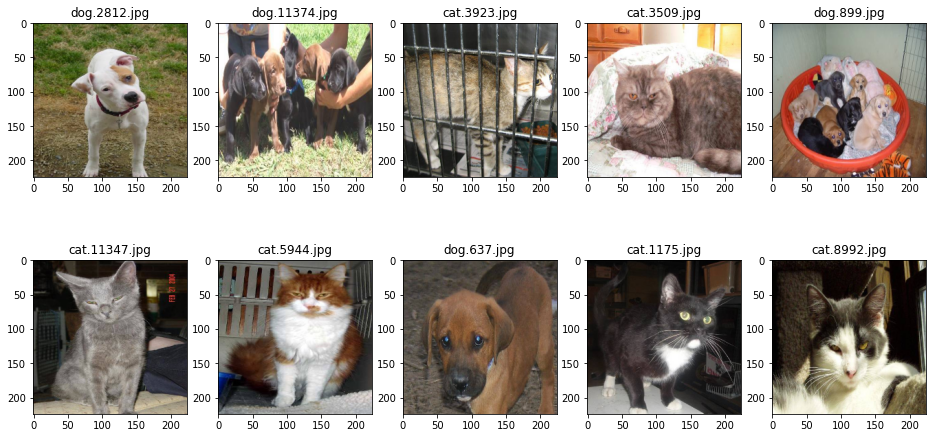

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

### Загружаем предобученную модель

In [ ]:
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58900480/58889256 [==============================] - 0s 0us/step


base_model - объект класса keras.models.Model (Functional Model)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Добавляем полносвязный слой

фиксируем все веса предобученной сети

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=4096,activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=2048,activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

### Выводим архитектуру модели

In [ ]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

### Компилируем модель и запускаем обучение

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

число изображений в валидационной выборке

In [ ]:
val_samples = 5

перемешиваем перемешиваем обучающую выборку

In [ ]:
shuffle(train_files)

In [ ]:
validation_data = next(fit_generator(train_files[:val_samples], val_samples))

данные читаем функцией-генератором

In [ ]:
train_data = fit_generator(train_files[val_samples:])

запускаем процесс обучения

In [ ]:
model.fit(train_data,
          steps_per_epoch=32,  # число вызовов генератора за эпоху
          epochs=20,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/20
32/32 [==============================] - 8s 249ms/step - loss: 4.2203 - accuracy: 0.8955 - val_loss: 0.0681 - val_accuracy: 1.0000
Epoch 2/20
32/32 [==============================] - 8s 247ms/step - loss: 2.3256 - accuracy: 0.9072 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 3/20
32/32 [==============================] - 8s 246ms/step - loss: 1.5868 - accuracy: 0.9092 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 4/20
32/32 [==============================] - 8s 256ms/step - loss: 1.2986 - accuracy: 0.9316 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 5/20
32/32 [==============================] - 8s 236ms/step - loss: 0.8988 - accuracy: 0.9209 - val_loss: 0.6765 - val_accuracy: 0.8000
Epoch 6/20
32/32 [==============================] - 7s 233ms/step - loss: 0.6684 - accuracy: 0.9121 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 7/20
32/32 [==============================] - 7s 232ms/step - loss: 0.3848 - accuracy: 0.9365 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 

In [ ]:
model.save('cats-dogs-vgg16.hdf5')

#### Предсказания на проверочной выборке

In [ ]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

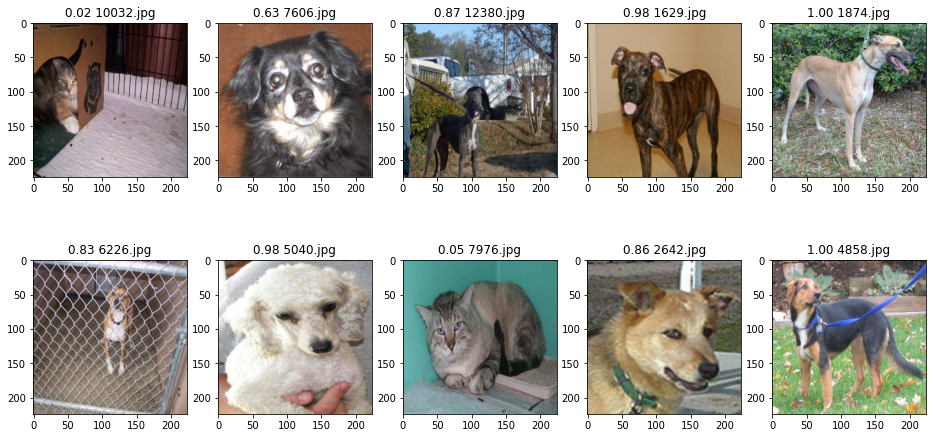

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

#### Готовим данные для отправки

In [ ]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

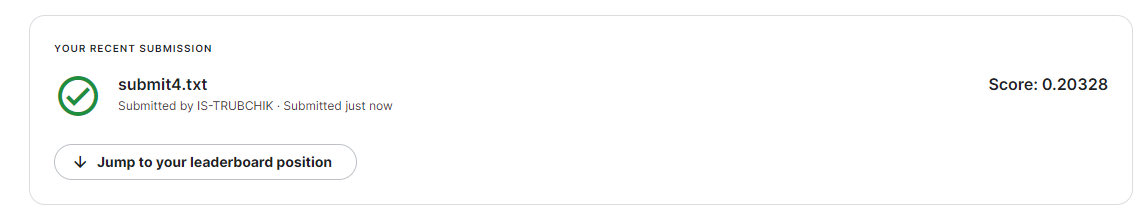